<a href="https://colab.research.google.com/github/denn98987/yolovideo/blob/main/Training_Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Data load


In [1]:
!curl 'https://motchallenge.net/data/MOT20Det.zip' -H 'User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:86.0) Gecko/20100101 Firefox/86.0' -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' -H 'Accept-Language: ru-RU,ru;q=0.8,en-US;q=0.5,en;q=0.3' --compressed -H 'Connection: keep-alive' -H 'Referer: https://motchallenge.net/data/MOT20Det/' -H 'Cookie: PHPSESSID=jljbeou0p3uqnubjv7h93c6uas' -H 'Upgrade-Insecure-Requests: 1' > 'data.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4788M  100 4788M    0     0  16.8M      0  0:04:43  0:04:43 --:--:-- 15.0M


In [2]:
!unzip data.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: MOT20Det/train/MOT20-05/img1/001749.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/002678.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/000191.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/003108.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/001639.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/001889.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/001945.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/000828.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/001705.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/001464.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/000252.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/002793.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/001323.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/002478.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/002976.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/001534.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/001678.jpg

In [ ]:
# !curl 'https://motchallenge.net/data/MOT17Det.zip' -H 'User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:84.0) Gecko/20100101 Firefox/84.0' -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' -H 'Accept-Language: ru-RU,ru;q=0.8,en-US;q=0.5,en;q=0.3' --compressed -H 'Connection: keep-alive' -H 'Referer: https://motchallenge.net/data/MOT17Det/' -H 'Cookie: PHPSESSID=jljbeou0p3uqnubjv7h93c6uas' -H 'Upgrade-Insecure-Requests: 1' > 'data2.zip'
# !unzip data2.zip

In [ ]:
# !rm -rf /content/train

In [3]:
!rm /content/data.zip

# Data preprocessing


In [4]:
import pandas as pd
import shutil
import os
import torch
from torchvision import transforms

from PIL import Image
import torchvision

In [ ]:
def normalize_sizes(df, width, height):
  df['bb_left'] /= width
  df['bb_top'] /= height
  df['bb_height'] /= height
  df['bb_width'] /= width

In [4]:
input()

''

check inside

In [34]:
!more /content/train/labels/train/100001.txt

0 0.103646 0.752778 0.072917 0.248148
0 0.180729 0.753704 0.064583 0.247222
0 0.207813 0.730556 0.054167 0.239815
0 0.859896 0.769444 0.052083 0.231481
0 0.347396 0.635185 0.050521 0.204630
0 0.395313 0.639815 0.048438 0.190741
0 0.824479 0.623148 0.060417 0.224074
0 0.870313 0.619444 0.039583 0.204630
6 0.641667 0.545370 0.030208 0.168519
0 0.782813 0.472222 0.027083 0.092593
6 0.697917 0.436111 0.030208 0.075926
0 0.766667 0.591667 0.040625 0.195370
0 0.743229 0.547222 0.042188 0.164815
0 0.606771 0.563889 0.034375 0.178704
0 0.534896 0.563889 0.041667 0.175926
0 0.716146 0.530556 0.033854 0.164815
0 0.384896 0.433333 0.023438 0.098148
0 0.397917 0.413889 0.026042 0.109259
0 0.410938 0.445370 0.025521 0.124074
0 0.420833 0.431481 0.026042 0.124074
0 0.425000 0.414815 0.028125 0.112963
0 0.456250 0.413889 0.030208 0.125926
0 0.455729 0.433333 0.027604 0.114815


In [41]:
df = pd.read_csv('/content/train/labels/train/100001.txt', names=['class', 'bb_left', 'bb_top', 'bb_width', 'bb_height'], sep=" ")

In [47]:
bboxes = df[(df['class']==0)]

In [ ]:
for index, row in bboxes.iterrows():
    print(row['frame'], row['bb_top'])

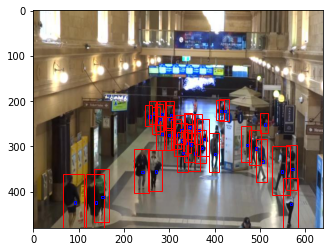

In [54]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = Image.open('/content/train/images/train/100001.jpg')

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)

for index, row in bboxes.iterrows():
  rect = patches.Rectangle((row['bb_left']*640, row['bb_top']*480), row['bb_width']*640, row['bb_height']*480, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  rect = patches.Rectangle(((row['bb_left']+row['bb_width']/2)*640, (row['bb_top']+row['bb_height']/2)*480), 5, 5, linewidth=1, edgecolor='b', facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(rect)

plt.show()

In [33]:

def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y

In [35]:

def xyxy2xywh(x):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = (x[:, 0] + x[:, 2]) / 2  # x center
    y[:, 1] = (x[:, 1] + x[:, 3]) / 2  # y center
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    return y

In [31]:
def scale_coords(img1_shape, coords, img0_shape, ratio_pad=None):
    # Rescale coords (xyxy) from img1_shape to img0_shape
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    coords[:, [0, 2]] -= pad[0]  # x padding
    coords[:, [1, 3]] -= pad[1]  # y padding
    coords[:, :4] /= gain
    clip_coords(coords, img0_shape)
    return coords


def clip_coords(boxes, img_shape):
    # Clip bounding xyxy bounding boxes to image shape (height, width)
    boxes[:, 0].clamp_(0, img_shape[1])  # x1
    boxes[:, 1].clamp_(0, img_shape[0])  # y1
    boxes[:, 2].clamp_(0, img_shape[1])  # x2
    boxes[:, 3].clamp_(0, img_shape[0])  # y2

In [66]:
df1 = pd.DataFrame([[1,2,3,4], [1,2,2,3], [1,2,2,3], [1,2,2,3]])
df1[:, [0,2]]

KeyError: ignored

In [42]:
import numpy as np


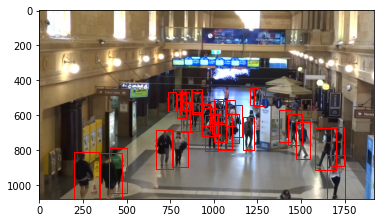

In [51]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = Image.open('/content/MOT20Det/train/MOT20-01/img1/000001.jpg')

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)

for index, row in bboxes.iterrows():
  coords = [row['bb_left']/1920, row['bb_top']/1080, row['bb_width']/1920, row['bb_height']/1080]
  # coords = scale_coords((1920, 1080), xywh2xyxy(coords), (640, 480))
  # coords = scale_coords([640, 480], coords, [1920, 1080])
  # coords = xyxy2xywh(coords)
  coords = [coords[0]*1920, coords[1]*1080, coords[2]*1920, coords[3]*1080]
  rect = patches.Rectangle((coords[:2]), coords[2], coords[3], linewidth=1, edgecolor='r', facecolor='none')

  # Add the patch to the Axes
  ax.add_patch(rect)

plt.show()

In [39]:
print([0,1,2][:2])

[0, 1]


In [32]:
input()

l


'l'

In [5]:
def normalize_sizes(df, w, h):
  df['bb_height'] /= h
  df['bb_width'] /= w
  df['bb_left'] /= w
  df['bb_top'] /= h

In [6]:
def to_files(df, path, frame):
  df = df[['class', 'bb_left', 'bb_top', 'bb_width', 'bb_height']]
  fpath = os.path.join(path, frame+'.txt')
  df.to_csv(fpath, header=False, index=False, float_format='%.6f', sep=" ")

In [55]:
!rm -rf /content/train

In [56]:
!cp -r /content/MOT20Det/train .

In [57]:
root = '/content/train'
for dname in os.listdir(root):
  #create labels
  local_dir_path = os.path.join(root, dname)
  label_path = os.path.join(local_dir_path, 'labels')
  if not os.path.isdir(label_path):
    os.mkdir(label_path)
  #read gt
  gt_path = os.path.join(local_dir_path, 'gt')
  gt_text_path = os.path.join(gt_path, 'gt.txt')
  if "/content/train/.ipynb_checkpoints" == local_dir_path:
    continue
  df = pd.read_csv(gt_text_path, names=['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'conf', 'class', '_'])
  df['class'] -= 1
  df['bb_left'] += (df['bb_width'] / 2)
  df['bb_top'] += (df['bb_height'] / 2) 
  if dname.startswith('MOT20-03'):
    normalize_sizes(df, 1173, 880)
  else if dname.startswith('MOT20-05'):
    normalize_sizes(df, 1173, 880)
  else:
    normalize_sizes(df, 1920, 1080)
  df.frame = df.frame.apply(lambda a: '{:0>6}'.format(int(dname[-1])*100000+a))
  if os.path.isdir(label_path):
    df = df.groupby(df["frame"]).apply(lambda _:to_files(_, label_path, _['frame'].any()))

SyntaxError: ignored

In [9]:
root = '/content/train'
for name in os.listdir(root):
  if ".ipynb_checkpoints" == name:
    continue
  locpath = os.path.join(os.path.join(root, name), 'img1')
  for nroot, _, files in os.walk(locpath, topdown=False):
    for fname in files:
      image = Image.open(os.path.join(nroot, fname))
      foldname = str(fname)
      fname = name[-1] + fname[1:]
      transform = transforms.Compose([
              transforms.Resize((240, 240)),  # interpolation `BILINEAR` is applied by default
              transforms.ToTensor()
              # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
          ])
      image = transform(image)
      torchvision.utils.save_image(image, os.path.join(nroot, fname))
      os.remove(os.path.join(nroot, foldname))

In [10]:
!cd train && mkdir images && cd images && mkdir train && mkdir val

In [11]:
!cd train && mkdir labels && cd labels && mkdir train && mkdir val

In [12]:
!cd /content/train/images/train && mkdir train
!cd /content/train/images/val && mkdir train

In [13]:
root = '/content/train'
target_img_train = '/content/train/images/train'
target_img_val = '/content/train/images/val'
target_lbl_train = '/content/train/labels/train'
target_lbl_val = '/content/train/labels/val'
for name_dir in os.listdir(root):
  local_dir_path = os.path.join(root, name_dir)
  img_path = os.path.join(local_dir_path, 'img1')
  labels_path = os.path.join(local_dir_path, 'labels')
  if name_dir == 'MOT20-01':
    for nroot, _, files in os.walk(img_path, topdown=False):
      for name in files:
        shutil.move(os.path.join(nroot, name), target_img_val)

    for nroot, _, files in os.walk(labels_path, topdown=False):
      for name in files:
        shutil.move(os.path.join(nroot, name), target_lbl_val)
    continue
  for nroot, _, files in os.walk(img_path, topdown=False):
    for name in files:
      shutil.move(os.path.join(nroot, name), target_img_train)

  for nroot, _, files in os.walk(labels_path, topdown=False):
    for name in files:
      shutil.move(os.path.join(nroot, name), target_lbl_train)
    
  
  

In [27]:
import shutil

In [28]:
root = '/content/train/images/train'
target_img_train = '/content/train/images/train'
target_img_val = '/content/train/images/val'
target_lbl_train = '/content/train/labels/train'
target_lbl_val = '/content/train/labels/val'
for nroot, _, files in os.walk(target_img_train, topdown=False):
  for name in files:
    if name.startswith('5'):
      shutil.move(os.path.join(target_img_train, name), os.path.join(target_img_val, name))


for nroot, _, files in os.walk(target_lbl_train, topdown=False):
  for name in files:
    if name.startswith('5'):
      shutil.move(os.path.join(target_lbl_train, name), os.path.join(target_lbl_val, name))


In [29]:
!ls /content/train/images/val

500001.jpg  500554.jpg	501107.jpg  501660.jpg	502213.jpg  502766.jpg
500002.jpg  500555.jpg	501108.jpg  501661.jpg	502214.jpg  502767.jpg
500003.jpg  500556.jpg	501109.jpg  501662.jpg	502215.jpg  502768.jpg
500004.jpg  500557.jpg	501110.jpg  501663.jpg	502216.jpg  502769.jpg
500005.jpg  500558.jpg	501111.jpg  501664.jpg	502217.jpg  502770.jpg
500006.jpg  500559.jpg	501112.jpg  501665.jpg	502218.jpg  502771.jpg
500007.jpg  500560.jpg	501113.jpg  501666.jpg	502219.jpg  502772.jpg
500008.jpg  500561.jpg	501114.jpg  501667.jpg	502220.jpg  502773.jpg
500009.jpg  500562.jpg	501115.jpg  501668.jpg	502221.jpg  502774.jpg
500010.jpg  500563.jpg	501116.jpg  501669.jpg	502222.jpg  502775.jpg
500011.jpg  500564.jpg	501117.jpg  501670.jpg	502223.jpg  502776.jpg
500012.jpg  500565.jpg	501118.jpg  501671.jpg	502224.jpg  502777.jpg
500013.jpg  500566.jpg	501119.jpg  501672.jpg	502225.jpg  502778.jpg
500014.jpg  500567.jpg	501120.jpg  501673.jpg	502226.jpg  502779.jpg
500015.jpg  500568.jpg	501121.jpg 

In [26]:
!ls /content/train/labels/val

# Train


In [14]:
!git clone https://github.com/ultralytics/yolov5


Cloning into 'yolov5'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 5056 (delta 11), reused 15 (delta 8), pack-reused 5032
Receiving objects: 100% (5056/5056), 7.96 MiB | 14.40 MiB/s, done.
Resolving deltas: 100% (3435/3435), done.


In [15]:
!cd yolov5 && pip install -r requirements.txt 

     |████████████████████████████████| 645kB 8.0MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [69]:
%reload_ext tensorboard


In [71]:
# Tensorboard (optional)
!cd yolov5/ && load_ext tensorboard && !tensorboard --logdir runs/train

/bin/bash: load_ext: command not found


//key for api below ef9a9fcc2cec66ad480386182cd38a1bb2fb91d3

In [16]:
%pip install -q wandb  
!wandb login 

     |████████████████████████████████| 2.0MB 7.9MB/s 
     |████████████████████████████████| 133kB 52.3MB/s 
     |████████████████████████████████| 163kB 35.1MB/s 
     |████████████████████████████████| 102kB 13.3MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


//get mot.yaml from me and put it in yolo dir


In [33]:
!cd yolov5 && python train.py --img-size 640 --batch 16 --epochs 5 --data mot.yaml --weights yolov5s.pt --nosave --cache-images

github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 v4.0-110-gfab5085 torch 1.7.1+cu101 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='', data='mot.yaml', device='', entity=None, epochs=5, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[640, 640], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=True, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp5', single_cls=False, sync_bn=False, total_batch_size=16, weights='yolov5s.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
2021-03-02 09:39:38.059193: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
hyperparameters: lr0=0.01, lrf=0.2, mo

In [18]:
!ls /content/train/images/val/train

In [ ]:
!ls /content/train/labels/train

000001.txt  000637.txt	 1000223.txt  2000022.txt  2000658.txt	3000544.txt
000002.txt  000638.txt	 1000224.txt  2000023.txt  2000659.txt	3000545.txt
000003.txt  000639.txt	 1000225.txt  2000024.txt  2000660.txt	3000546.txt
000004.txt  000640.txt	 1000226.txt  2000025.txt  2000661.txt	3000547.txt
000005.txt  000641.txt	 1000227.txt  2000026.txt  2000662.txt	3000548.txt
000006.txt  000642.txt	 1000228.txt  2000027.txt  2000663.txt	3000549.txt
000007.txt  000643.txt	 1000229.txt  2000028.txt  2000664.txt	3000550.txt
000008.txt  000644.txt	 1000230.txt  2000029.txt  2000665.txt	3000551.txt
000009.txt  000645.txt	 1000231.txt  2000030.txt  2000666.txt	3000552.txt
000010.txt  000646.txt	 1000232.txt  2000031.txt  2000667.txt	3000553.txt
000011.txt  000647.txt	 1000233.txt  2000032.txt  2000668.txt	3000554.txt
000012.txt  000648.txt	 1000234.txt  2000033.txt  2000669.txt	3000555.txt
000013.txt  000649.txt	 1000235.txt  2000034.txt  2000670.txt	3000556.txt
000014.txt  000650.txt	 1000236.txt  2

In [ ]:
!ls /content/train/images/train

100001.jpg  100462.jpg	200086.jpg  200547.jpg	300258.jpg  400065.jpg
100002.jpg  100463.jpg	200087.jpg  200548.jpg	300259.jpg  400066.jpg
100003.jpg  100464.jpg	200088.jpg  200549.jpg	300260.jpg  400067.jpg
100004.jpg  100465.jpg	200089.jpg  200550.jpg	300261.jpg  400068.jpg
100005.jpg  100466.jpg	200090.jpg  200551.jpg	300262.jpg  400069.jpg
100006.jpg  100467.jpg	200091.jpg  200552.jpg	300263.jpg  400070.jpg
100007.jpg  100468.jpg	200092.jpg  200553.jpg	300264.jpg  400071.jpg
100008.jpg  100469.jpg	200093.jpg  200554.jpg	300265.jpg  400072.jpg
100009.jpg  100470.jpg	200094.jpg  200555.jpg	300266.jpg  400073.jpg
100010.jpg  100471.jpg	200095.jpg  200556.jpg	300267.jpg  400074.jpg
100011.jpg  100472.jpg	200096.jpg  200557.jpg	300268.jpg  400075.jpg
100012.jpg  100473.jpg	200097.jpg  200558.jpg	300269.jpg  400076.jpg
100013.jpg  100474.jpg	200098.jpg  200559.jpg	300270.jpg  400077.jpg
100014.jpg  100475.jpg	200099.jpg  200560.jpg	300271.jpg  400078.jpg
100015.jpg  100476.jpg	200100.jpg 

# The End / Trash

In [ ]:
!cp -r /content/train/MOT17-02/img1 /content/train/images

In [ ]:
!rm -rf /content/train/images/val
!cp -r /content/train/MOT17-04/img1/train /content/train/images/val

In [ ]:

!cp -r /content/train/MOT17-02/labels /content/train/labels

In [ ]:
!rm -rf /content/train/labels/val
!cp -r /content/train/MOT17-04/labels/train /content/train/labels/val

In [ ]:
!rm -rf /content/train/labels/train
!cp -r /content/train/MOT17-02/labels/train /content/train/labels/train

In [ ]:
root = '/content/train'
for name in os.listdir(root):
  local_dir_path = os.path.join(root, name)
  img_path = os.path.join(local_dir_path, 'img1')
  for root, dirs, files in os.walk(img_path, topdown=False):
    for name in files:
        print(os.path.join(root, name))

In [ ]:
root = '/content/train'
for name_dir in os.listdir(root):
  if name_dir == 'MOT17-09':
    continue
  local_dir_path = os.path.join(root, name_dir)
  img_path = os.path.join(local_dir_path, 'img1')
  img_train_path = os.path.join(img_path, 'train')
  if not os.path.isdir(img_train_path):
    os.mkdir(img_train_path)

  labels_path = os.path.join(local_dir_path, 'labels')
  labels_train_path = os.path.join(labels_path, 'train')
  if not os.path.isdir(labels_train_path):
    os.mkdir(labels_train_path)

  for nroot, _, files in os.walk(img_path, topdown=False):
    for name in files:
      shutil.move(os.path.join(nroot, name), img_train_path)

  for nroot, _, files in os.walk(labels_path, topdown=False):
    for name in files:
      shutil.move(os.path.join(nroot, name), labels_train_path)
  

In [ ]:
!curl 'https://motchallenge.net/data/MOT17Det.zip' -H 'User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:84.0) Gecko/20100101 Firefox/84.0' -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' -H 'Accept-Language: ru-RU,ru;q=0.8,en-US;q=0.5,en;q=0.3' --compressed -H 'Connection: keep-alive' -H 'Referer: https://motchallenge.net/data/MOT17Det/' -H 'Cookie: PHPSESSID=jljbeou0p3uqnubjv7h93c6uas' -H 'Upgrade-Insecure-Requests: 1' > 'data2.zip'
!unzip data2.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/MOT17-02/img1/000323.jpg  
  inflating: train/MOT17-02/img1/000324.jpg  
  inflating: train/MOT17-02/img1/000325.jpg  
  inflating: train/MOT17-02/img1/000326.jpg  
  inflating: train/MOT17-02/img1/000327.jpg  
  inflating: train/MOT17-02/img1/000328.jpg  
  inflating: train/MOT17-02/img1/000329.jpg  
  inflating: train/MOT17-02/img1/000330.jpg  
  inflating: train/MOT17-02/img1/000331.jpg  
  inflating: train/MOT17-02/img1/000332.jpg  
  inflating: train/MOT17-02/img1/000333.jpg  
  inflating: train/MOT17-02/img1/000334.jpg  
  inflating: train/MOT17-02/img1/000335.jpg  
  inflating: train/MOT17-02/img1/000336.jpg  
  inflating: train/MOT17-02/img1/000337.jpg  
  inflating: train/MOT17-02/img1/000338.jpg  
  inflating: train/MOT17-02/img1/000339.jpg  
  inflating: train/MOT17-02/img1/000340.jpg  
  inflating: train/MOT17-02/img1/000341.jpg  
  inflating: train/MOT17-02/img1/000342.jpg  
  inflating:

In [ ]:
def renormalize_sizes(df, width, height, oldwidth, oldheight):
  df['bb_left'] *= oldwidth / width
  df['bb_top'] *= oldheight / height
  df['bb_height'] *= oldheight / height
  df['bb_width'] *= oldwidth / width

In [ ]:
for nroot, _, files in os.walk('/content/train/labels/train', topdown=False):
  for name in files:
    df = pd.read_csv(os.path.join(nroot, name), names=['class', 'bb_left', 'bb_top', 'bb_width', 'bb_height'], sep=',')
    renormalize_sizes(df,1920, 1080, 640, 480)
    df.to_csv(os.path.join(nroot, name), header=False, index=False, float_format='%.6f', sep=" ")


In [ ]:
for nroot, _, files in os.walk('/content/train/images/train', topdown=False):
  for name in files:
    image = Image.open(os.path.join(nroot, name))
    transform = transforms.Compose([
            transforms.Resize((480, 640)),  # interpolation `BILINEAR` is applied by default
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    image = transform(image)
    torchvision.utils.save_image(image, os.path.join(nroot, name))